In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()
from tqdm.notebook import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

## NSD images

In [2]:
df = pd.read_csv("data/memorability_controlled/shared1000_singleclass_stepsize20_240.csv")
new_cols = [c for c in df.columns[2:] if int(c) >= -180 and int(c) <= 180]
new_cols.insert(0, "nsd_id")
new_cols.insert(1, "imagenet_class_idx")
df = df.loc[:, new_cols]
df.head()

,nsd_id,imagenet_class_idx,-180,-160,-140,-120,-100,-80,-60,-40,...,0,20,40,60,80,100,120,140,160,180
0,shared0001,582,0.981048,0.976800,0.836033,0.831021,0.775983,0.783099,0.833192,0.715590,...,0.744177,0.875148,0.887222,0.867261,0.805751,0.693494,0.675864,0.715411,0.714102,0.682737
1,shared0003,842,0.676499,0.569782,0.498104,0.400352,0.290865,0.347873,0.321161,0.368506,...,0.553760,0.543680,0.495914,0.449182,0.497998,0.569379,0.596777,0.593143,0.663457,0.592867
2,shared0004,484,0.349201,0.305232,0.286102,0.281080,0.303875,0.305589,0.316031,0.425468,...,0.651503,0.576971,0.579635,0.597239,0.666150,0.672945,0.631445,0.624931,0.635186,0.573688
3,shared0005,497,0.286297,0.333344,0.312613,0.359189,0.404158,0.421206,0.403593,0.401991,...,0.640173,0.646676,0.615186,0.654405,0.640001,0.656900,0.705210,0.779187,0.826777,0.818052
4,shared0008,768,0.513048,0.509745,0.454805,0.430838,0.355592,0.311154,0.362104,0.401000,...,0.611571,0.612031,0.666429,0.618111,0.665728,0.635149,0.690697,0.707302,0.798485,0.796513


In [3]:
stats_dict = {"nsd_id": [], "imagenet_class_idx": [], "mem_coef": [], "memorability": []}
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    stats_dict["nsd_id"].extend([row['nsd_id']]*19)
    stats_dict["imagenet_class_idx"].extend([int(row['imagenet_class_idx'])]*19)
    for k, v in row.items():
        if k in ["imagenet_class_idx", "nsd_id"]:
            continue
        else:
            stats_dict["mem_coef"].append(int(k))
            stats_dict["memorability"].append(v)

  0%|          | 0/856 [00:00<?, ?it/s]

In [4]:
stats_df = pd.DataFrame(stats_dict)
stats_df["mem_coef"] = stats_df["mem_coef"] // 20
print(stats_df.shape)
stats_df.head()

(16264, 4)


,nsd_id,imagenet_class_idx,mem_coef,memorability
0,shared0001,582,-9,0.981048
1,shared0001,582,-8,0.976800
2,shared0001,582,-7,0.836033
3,shared0001,582,-6,0.831021
4,shared0001,582,-5,0.775983


In [5]:
md = smf.mixedlm("memorability ~ mem_coef", stats_df, groups=stats_df["nsd_id"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: memorability
No. Observations: 16264   Method:             REML        
No. Groups:       856     Scale:              0.0127      
Min. group size:  19      Log-Likelihood:     11206.5456  
Max. group size:  19      Converged:          Yes         
Mean group size:  19.0                                    
-----------------------------------------------------------
            Coef.  Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept   0.575     0.004  154.652  0.000   0.568   0.583
mem_coef    0.012     0.000   72.435  0.000   0.011   0.012
Group Var   0.011     0.005                                



In [6]:
model = sm.OLS(stats_df["memorability"], stats_df["mem_coef"])  # note y first, then X with 2 columns
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:           memorability   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              187.3
Date:                Fri, 19 Apr 2024   Prob (F-statistic):                    2.09e-42
Time:                        16:46:16   Log-Likelihood:                         -14650.
No. Observations:               16264   AIC:                                  2.930e+04
Df Residuals:                   16263   BIC:                                  2.931e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [7]:
group_df = stats_df.iloc[:, 2:]
group_df = group_df.reset_index(drop=True)
group_df.head()

,mem_coef,memorability
0,-9,0.981048
1,-8,0.976800
2,-7,0.836033
3,-6,0.831021
4,-5,0.775983


In [8]:
viz_df = group_df.groupby("mem_coef")

mean_arr = viz_df.mean().values.flatten()
std_arr = viz_df.std().values.flatten()
x_labels = viz_df.mean().index

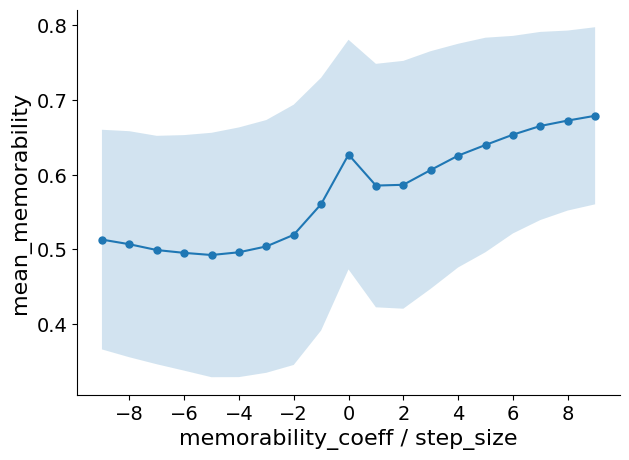

In [20]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_labels, mean_arr, marker="o", markersize=5)
# ax.plot(x_labels, mean_arr - std_arr, color='tab:blue', alpha=0.1)
# ax.plot(x_labels, mean_arr + std_arr, color='tab:blue', alpha=0.1)
ax.fill_between(x_labels, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2)
ax.set_xlabel('memorability_coeff / step_size', fontsize=16)
ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
plt.xticks(fontsize=14)
ax.set_ylabel('mean_memorability', fontsize=16)
plt.yticks(fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.show()
plt.savefig("data/memorability_controlled/memorability_change.png", bbox_inches='tight')

## Synthesized images

In [10]:
df = pd.read_csv("data/synthetic_memorability_controlled/singleclass_stepsize5_200.csv")
new_cols = [c for c in df.columns[2:] if int(c) >= -45 and int(c) <= 45]
# new_cols = [c for c in df.columns[2:] if int(c) % 10 == 0]
# new_cols = [c for c in df.columns[2:] if int(c) >= -50 and int(c) <= 50 and int(c) % 10 == 0]
new_cols.insert(0, "imagenet_class_idx")
new_cols.insert(1, "dlat_idx")
df = df.loc[:, new_cols]
df.head()

,imagenet_class_idx,dlat_idx,-45,-40,-35,-30,-25,-20,-15,-10,...,0,5,10,15,20,25,30,35,40,45
0,9,6480,0.529918,0.505499,0.502890,0.503013,0.530741,0.570884,0.596198,0.588869,...,0.632537,0.677149,0.623385,0.827038,0.858864,0.858118,0.833314,0.800776,0.782371,0.738244
1,9,2760,0.600297,0.604604,0.587420,0.592479,0.608965,0.643998,0.641672,0.650756,...,0.636450,0.711784,0.771258,0.809601,0.834635,0.849380,0.858752,0.876283,0.869089,0.882428
2,9,298,0.525862,0.544988,0.535175,0.544917,0.552151,0.556072,0.562643,0.567954,...,0.586012,0.658672,0.751419,0.800738,0.848542,0.866237,0.860884,0.863905,0.860544,0.855518
3,9,5072,0.646925,0.634739,0.639994,0.662482,0.677904,0.659155,0.602407,0.620561,...,0.622409,0.777211,0.837117,0.860152,0.869546,0.881787,0.884466,0.882427,0.889278,0.871627
4,9,499,0.606332,0.658334,0.701498,0.743814,0.734880,0.700772,0.668106,0.638764,...,0.749610,0.801036,0.847322,0.878379,0.889840,0.901661,0.908367,0.901842,0.879103,0.842586


In [11]:
stats_dict = {"image_id": [], "mem_coef": [], "memorability": []}
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    image_id = f"{int(row['imagenet_class_idx'])}_{int(row['dlat_idx'])}"
    stats_dict["image_id"].extend([image_id]*19)
    for k, v in row.items():
        if k in ["imagenet_class_idx", "dlat_idx"]:
            continue
        else:
            stats_dict["mem_coef"].append(int(k))
            stats_dict["memorability"].append(v)

  0%|          | 0/1380 [00:00<?, ?it/s]

In [12]:
stats_df = pd.DataFrame(stats_dict)
# stats_df = stats_df[(stats_df["mem_coef"] <= 50) & (stats_df["mem_coef"] >= -50)].copy()
stats_df["mem_coef"] = stats_df["mem_coef"] // 5
# stats_df["imagenet_class_idx"] = stats_df["imagenet_class_idx"].astype(int)
# stats_df["dlat_idx"] = stats_df["dlat_idx"].astype(int)
print(stats_df.shape)
stats_df.head()

(26220, 3)


,image_id,mem_coef,memorability
0,9_6480,-9,0.529918
1,9_6480,-8,0.505499
2,9_6480,-7,0.502890
3,9_6480,-6,0.503013
4,9_6480,-5,0.530741


In [13]:
md = smf.mixedlm("memorability ~ mem_coef", stats_df, groups=stats_df["image_id"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: memorability
No. Observations: 26220   Method:             REML        
No. Groups:       1380    Scale:              0.0069      
Min. group size:  19      Log-Likelihood:     25350.9128  
Max. group size:  19      Converged:          Yes         
Mean group size:  19.0                                    
-----------------------------------------------------------
            Coef.  Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept   0.693     0.004  191.237  0.000   0.685   0.700
mem_coef    0.025     0.000  270.619  0.000   0.025   0.026
Group Var   0.018     0.009                                



In [14]:
model = sm.OLS(stats_df["memorability"], stats_df["mem_coef"])  # note y first, then X with 2 columns
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:           memorability   R-squared (uncentered):                   0.037
Model:                            OLS   Adj. R-squared (uncentered):              0.037
Method:                 Least Squares   F-statistic:                              1000.
Date:                Wed, 17 Apr 2024   Prob (F-statistic):                   2.01e-215
Time:                        18:45:16   Log-Likelihood:                         -28228.
No. Observations:               26220   AIC:                                  5.646e+04
Df Residuals:                   26219   BIC:                                  5.647e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [15]:
group_df = stats_df.iloc[:, 1:]
group_df = group_df.reset_index(drop=True)
group_df.head()

,mem_coef,memorability
0,-9,0.529918
1,-8,0.505499
2,-7,0.502890
3,-6,0.503013
4,-5,0.530741


In [16]:
viz_df = group_df.groupby("mem_coef")

mean_arr = viz_df.mean().values.flatten()
std_arr = viz_df.std().values.flatten()
x_labels = viz_df.mean().index

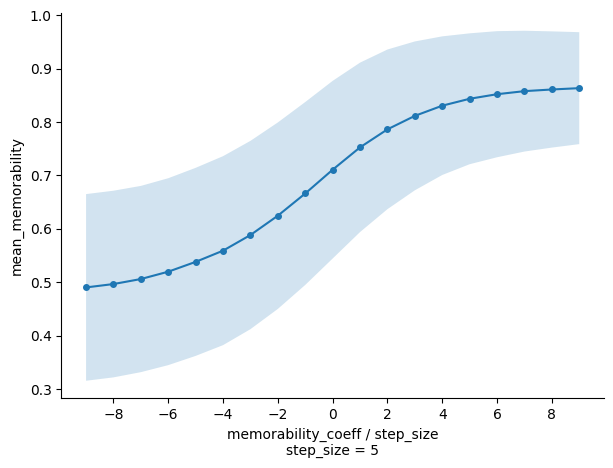

In [17]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_labels, mean_arr, marker="o", markersize=4)
# ax.plot(x_labels, mean_arr - std_arr, color='tab:blue', alpha=0.1)
# ax.plot(x_labels, mean_arr + std_arr, color='tab:blue', alpha=0.1)
ax.fill_between(x_labels, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2)
ax.set_xlabel('memorability_coeff / step_size\nstep_size = 5')
ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
ax.set_ylabel('mean_memorability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("data/synthetic_memorability_controlled/memorability_change.png", bbox_inches='tight')